In [45]:
import numpy as np
from scipy.linalg import solve

In [46]:
def constructMatrix(nx, ny, sigma):
    """ Generate implicit matrix for 2D heat equation with Dirichlet in bottom and right and Neumann in top and left
        Assumes dx = dy
    
    Parameters:
    ----------
    nx   : int
        number of discretization points in x
    ny   : int
        number of discretization points in y
    sigma: float
        alpha*dt/dx
        
    Returns:
    -------
    A: 2D array of floats
        Matrix of implicit 2D heat equation
    """
    
    A = np.zeros(((nx-2)*(ny-2),(nx-2)*(ny-2)))
    
    row_number = 0 # row counter
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            
            # Corners
            if i==1 and j==1: # Bottom left corner (Dirichlet down and left)
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                
            elif i==nx-2 and j==1: # Bottom right corner (Dirichlet down, Neumann right)
                A[row_number,row_number] = 1/sigma+3 # Set diagonal
                A[row_number,row_number-1] = -1      # Fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                
            elif i==1 and j==ny-2: # Top left corner (Neumann up, Dirichlet left)
                A[row_number,row_number] = 1/sigma+3   # Set diagonal
                A[row_number,row_number+1] = -1        # fetch i+1
                A[row_number,row_number-(nx-2)] = -1   # fetch j-1
                
            elif i==nx-2 and j==ny-2: # Top right corner (Neumann up and right)
                A[row_number,row_number] = 1/sigma+2   # Set diagonal
                A[row_number,row_number-1] = -1        # Fetch i-1
                A[row_number,row_number-(nx-2)] = -1   # fetch j-1
              
            # Sides
            elif i==1: # Left boundary (Dirichlet)
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
            
            elif i==nx-2: # Right boundary (Neumann)
                A[row_number,row_number] = 1/sigma+3 # Set diagonal
                A[row_number,row_number-1] = -1      # Fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
                
            elif j==1: # Bottom boundary (Dirichlet)
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                
            elif j==ny-2: # Top boundary (Neumann)
                A[row_number,row_number] = 1/sigma+3 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
                
            # Interior points
            else:
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
                
            row_number += 1 # Jump to next row of the matrix!
    
    return A

In [47]:
def generateRHS(nx, ny, sigma, T, T_bc):
    """ Generates right-hand side for 2D implicit heat equation with Dirichlet in bottom and left and Neumann in top and right
        Assumes dx=dy, Neumann BCs = 0, and constant Dirichlet BCs
        
        Paramenters:
        -----------
        nx   : int
            number of discretization points in x
        ny   : int
            number of discretization points in y
        sigma: float
            alpha*dt/dx
        T    : array of float
            Temperature in current time step
        T_bc : float
            Temperature in Dirichlet BC
        
        Returns:
        -------
        RHS  : array of float
            Right hand side of 2D implicit heat equation
    """
    RHS = np.zeros((nx-2)*(ny-2))
    
    row_number = 0 # row counter
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            
            # Corners
            if i==1 and j==1: # Bottom left corner (Dirichlet down and left)
                RHS[row_number] = T[j,i]*1/sigma + 2*T_bc
                
            elif i==nx-2 and j==1: # Bottom right corner (Dirichlet down, Neumann right)
                RHS[row_number] = T[j,i]*1/sigma + T_bc
                           
            elif i==1 and j==ny-2: # Top left corner (Neumann up, Dirichlet left)
                RHS[row_number] = T[j,i]*1/sigma + T_bc
                
            elif i==nx-2 and j==ny-2: # Top right corner (Neumann up and right)
                RHS[row_number] = T[j,i]*1/sigma 
              
            # Sides
            elif i==1: # Left boundary (Dirichlet)
                RHS[row_number] = T[j,i]*1/sigma + T_bc
            
            elif i==nx-2: # Right boundary (Neumann)
                RHS[row_number] = T[j,i]*1/sigma 
                
            elif j==1: # Bottom boundary (Dirichlet)
                RHS[row_number] = T[j,i]*1/sigma + T_bc
                
            elif j==ny-2: # Top boundary (Neumann)
                RHS[row_number] = T[j,i]*1/sigma
                
            # Interior points
            else:
                RHS[row_number] = T[j,i]*1/sigma 
                
            row_number += 1 # Jump to next row!
    
    return RHS

In [48]:
def map_1Dto2D(nx, ny, T_1D, T_bc):
    """ Takes temperatures of solution of linear system, stored in 1D, 
    and puts them in a 2D array with the BCs
    Valid for constant Dirichlet bottom and left, and Neumann with zero 
    flux top and right
        
    Parameters:
    ----------
        nx  : int
            number of nodes in x direction
        ny  : int
            number of nodes in y direction
        T_1D: array of floats
            solution of linear system
        T_bc: float
            Dirichlet BC
            
    Returns:
    -------
        T: 2D array of float
            Temperature stored in 2D array with BCs
    """
    T = np.zeros((ny,nx))
    
    row_number = 0
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            T[j,i] = T_1D[row_number]
            row_number += 1
    # Dirichlet BC
    T[0,:] = T_bc
    T[:,0] = T_bc
    #Neumann BC
    T[-1,:] = T[-2,:]
    T[:,-1] = T[:,-2]
    
    return T

In [49]:
def btcs_2D(T, A, nt, sigma, T_bc, nx, ny, dt):
    """ Advances diffusion equation in time with backward Euler
   
    Parameters:
    ----------
    T: 2D array of float
        initial temperature profile
    A: 2D array of float
        Matrix with discretized diffusion equation
    nt: int
        number of time steps
    sigma: float
        alpha*dt/dx^2
    T_bc : float 
        Dirichlet BC temperature
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    dt   : float
        Time step size
        
    Returns:
    -------
    T: 2D array of floats
        temperature profile after nt time steps
    """
    
    j_mid = (np.shape(T)[0])/2
    i_mid = (np.shape(T)[1])/2
    
    for t in range(nt):
        Tn = T.copy()
        b = generateRHS(nx, ny, sigma, Tn, T_bc)
        # Use numpy.linalg.solve
        T_interior = solve(A,b)
        T = map_1Dto2D(nx, ny, T_interior, T_bc)
        
        # Check if we reached T=70C
        if T[j_mid, i_mid] >= 70:
            print ("Center of plate reached 70C at time {0:.2f}s, in time step {1:d}.".format(dt*t, t))
            break
        
    if T[j_mid, i_mid]<70:
        print ("Center has not reached 70C yet, it is only {0:.2f}C.".format(T[j_mid, i_mid]))
        
    return T

In [50]:
# Simpler generate Matrix?

## 2D Heat diffusion

In [51]:
# Initial Condition and Parameters
alpha = 1e-4

L = 1.0e-2
H = 1.0e-2

nx = 21
ny = 21
nt = 300

dx = L/(nx-1)
dy = H/(ny-1)

x = np.linspace(0,L,nx)
y = np.linspace(0,H,ny)

T_bc = 100

Ti = np.ones((ny,nx))*20
Ti[0,:] = T_bc
Ti[:,0] = T_bc

In [52]:
sigma = 0.25
A = constructMatrix(nx, ny, sigma)

In [53]:
dt = sigma * min(dx, dy)**2 / alpha
T = btcs_2D(Ti.copy(), A, nt, sigma, T_bc, nx, ny, dt)

C:\Users\Amiya\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Amiya\Anaconda3\lib\site-packages\ipykernel\__main__.py:44: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Center of plate reached 70C at time 0.16s, in time step 256.


In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

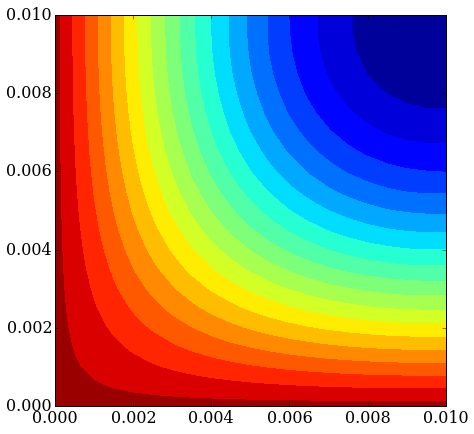

In [55]:
mx, my = np.meshgrid(x, y)
plt.figure(figsize=(7,7))
plt.contourf(my,mx,T,20);